### Area of Medical Services Shortage Classification (LGBM Multi-Class)

1. Data was first pre-processed and load the final version of la_facility_mua.csv here

2. Since feature engineering has been done, a few touch-ups before training:

a) **Feature Mapping,**

b) **Dropping useless variables,**

c) **Datetime conversion,**

d) **Days Diff**

3. We have 51-classes of Zip Codes.

a) Group Zip Codes into **10** categories(0-9) based on **Severity of Shortage**

b) **9** represents the **Highest Shortage** while **0** represents the **Lowest Shortage**

c) Name the new variable as **'Zip Class'** which is our **Target** (what we will try to predict here)**

4. Data was split into Train and Validation

5. Model: **LGBMClassifier**

6. 2 Methods:

a) Method-1: Simple train-test-split

b) Method-2: 6-StratifiedKFold

In [2]:
import os
os.environ['PYTHONHASHSEED']='0'

In [3]:
import pandas as pd
import numpy as np
import random as rn
# Deep Learning Libraries
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.layers import Conv1D,MaxPool1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
import tensorflow as tf
np.random.seed(37)
rn.seed(42)
tf.random.set_seed(42)
from keras import backend as K

Using TensorFlow backend.


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
from math import sqrt 
from sklearn.metrics import log_loss
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc,roc_auc_score
from catboost import CatBoostClassifier,Pool, cv
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold

la_facility_mua = pd.read_csv('../input/la-final-data-2/la_facility_mua.csv')

In [5]:
la_facility_mua.head()

,source,cat1,cat2,org_name,Name,addrln1,city,state,post_id,description,...,facility_address_1,MUA_RuralStatus,MUA_Designated_Time,MUA_Designated_Date,MUA_MSSA_Name_1,MUA_Updated_Time,MUA_Updated_Date,MUA_Poverty,MUA_Score,MUA_Pct_100Poverty
0,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,415 South Union Avenue,Urban,1.067990e+12,2003-11-05,MSSA 78.2b (Pico Union/Westlake),1.067990e+12,2003-11-05,157757.0,51.0,0.0
1,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,600 St Paul Ave,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0
2,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,1125 W 6th St,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0
3,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,1225 Wilshire Boulevard,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0
4,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,1127 Wilshire Blvd,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0


In [9]:
zip_score = {
    'MUA_Score': ['mean'],
}
zip_score = la_facility_mua.groupby(['Zip Code']).agg(zip_score)
zip_score.columns = ['ByZipCode_' + ('_'.join(col).strip()) for col in zip_score.columns.values]
zip_score.reset_index(inplace=True)

In [10]:
zip_score = zip_score.sort_values(by=['ByZipCode_MUA_Score_mean'], ascending=True)

In [11]:
zip_score.head()

,Zip Code,ByZipCode_MUA_Score_mean
18,90044,48.350000
7,90013,50.200000
15,90037,50.857143
5,90011,50.914286
2,90006,51.000000


In [12]:
la_facility_mua['Zip Class'] = la_facility_mua['Zip Code'].map({
90044:9, 90013:9, 90037:9, 90011:9, 90006:9,
90002:8, 90059:8, 90047:8, 90255:8, 90018:8,
90007:7, 90221:7, 90003:7, 90015:7, 90010:7,
90012:6, 91601:6, 90220:6, 90057:6, 91606:6,
91767:5, 91768:5, 91766:5, 90043:5, 90302:5,
90033:4, 90262:4, 91770:4, 91731:4, 90248:4,
91205:3, 91101:3, 90026:3, 91605:3, 90017:3,
90813:2, 91340:2, 90802:2, 90805:2, 90806:2,
90020:1, 91331:1, 90042:1, 90031:1, 90250:1,
91401:0, 91405:0, 90731:0, 91406:0, 90744:0, 91411:0})

la_facility_mua['Zip Class'] = la_facility_mua['Zip Class'].astype('int32')

In [13]:
la_facility_mua['Zip Class'].value_counts().sort_values(ascending=False)

0    2094
6    2067
7    1242
2    1230
4    1013
3     961
9     613
1     455
5     453
8     377
Name: Zip Class, dtype: int64

In [14]:
la_facility_mua.rename({'cat1': 'Category Service'}, axis=1, inplace=True)

In [15]:
la_facility_mua['Category Service'].value_counts().sort_values(ascending=False)

Health and Mental Health    4858
Social Services             4330
Public Safety               1317
Name: Category Service, dtype: int64

In [16]:
la_facility_mua['Category Service']=la_facility_mua['Category Service'].map({
'Health and Mental Health':0,
'Social Services':1,
'Public Safety':2
})
la_facility_mua['Category Service']=la_facility_mua['Category Service'].astype('int32')

In [18]:
la_facility_mua['facility_er_service'] = la_facility_mua['facility_er_service'].map({
'Not Applicable':'Not Applicable',
'None':'Not Applicable',
'Emergency - Basic':'Emergency',
'Emergency - Comprehensive':'Emergency',
'Emergency - Standby':'Emergency'
})

In [19]:
la_facility_mua['MUA_Poverty']=la_facility_mua['MUA_Poverty'].map({
157757.0:2,
129447.0:1,
0.0:0,
})

In [24]:
la_facility_mua['MUA_Designated_Date'] = pd.to_datetime(la_facility_mua['MUA_Designated_Date']) 
la_facility_mua['MUA_Updated_Date'] = pd.to_datetime(la_facility_mua['MUA_Updated_Date']) 
la_facility_mua['Date Difference'] = la_facility_mua['MUA_Updated_Date']-la_facility_mua['MUA_Designated_Date']

In [25]:
def ddiff2days(ddiff):
    if not pd.isnull(ddiff):
        return pd.Timedelta.total_seconds(ddiff)/(24.*3600)
    else:
        return np.NaN

In [26]:
la_facility_mua['Date Difference']=la_facility_mua['Date Difference'].apply(ddiff2days)
la_facility_mua['Date Difference']=la_facility_mua['Date Difference'].astype('int32')

In [27]:
la_facility_mua['design_year'] = (la_facility_mua['MUA_Designated_Date'].dt.year).astype('int32')
la_facility_mua['design_month'] = (la_facility_mua['MUA_Designated_Date'].dt.month).astype('int32')
la_facility_mua['design_week'] = (la_facility_mua['MUA_Designated_Date'].dt.week).astype('int32')
la_facility_mua['design_dow'] = (la_facility_mua['MUA_Designated_Date'].dt.dayofweek).astype('int32')

la_facility_mua['update_year'] = (la_facility_mua['MUA_Updated_Date'].dt.year).astype('int32')
la_facility_mua['update_month'] = (la_facility_mua['MUA_Updated_Date'].dt.month).astype('int32')
la_facility_mua['update_week'] = (la_facility_mua['MUA_Updated_Date'].dt.week).astype('int32')
la_facility_mua['update_dow'] = (la_facility_mua['MUA_Updated_Date'].dt.dayofweek).astype('int32')

In [29]:
la_facility_mua.drop(['MUA_Designated_Date', 'MUA_Updated_Date', 'Zip Code',                  
 ], axis=1, inplace=True)

In [30]:
cols = [c for c in la_facility_mua.columns if la_facility_mua[c].dtypes=='object']
for c in cols:
    le = LabelEncoder()
    la_facility_mua[c] = (le.fit_transform(la_facility_mua[c])).astype('int32')

In [32]:
X = la_facility_mua.drop(labels=['Zip Class'], axis=1)
y = la_facility_mua['Zip Class']

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=tf.random.set_seed(42))

In [33]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'num_iterations': 1500,
         'num_leaves': 31,
         'max_depth': -1,
         'learning_rate': 0.01, 
         'num_class': 10,
         'objective': 'multiclass',
         'metric': 'multi_logloss',
         'min_data_per_group': 110,
         'feature_fraction': 0.6,
         'bagging_fraction':0.8,
         'bagging_freq': 5,
         'boosting': 'gbdt',
         'is_unbalance':True,
         'seed':42
         }

clf = lgb.train(params=param, 
                early_stopping_rounds=20,
                verbose_eval=50,
                train_set=train_data,
                valid_sets=[train_data, test_data])

y_pred = clf.predict(X_cv)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
[50]	training's multi_logloss: 1.24952	valid_1's multi_logloss: 1.26749
[100]	training's multi_logloss: 0.847686	valid_1's multi_logloss: 0.865842
[150]	training's multi_logloss: 0.608635	valid_1's multi_logloss: 0.626966
[200]	training's multi_logloss: 0.450985	valid_1's multi_logloss: 0.468911
[250]	training's multi_logloss: 0.341897	valid_1's multi_logloss: 0.35929
[300]	training's multi_logloss: 0.267301	valid_1's multi_logloss: 0.284495
[350]	training's multi_logloss: 0.211229	valid_1's multi_logloss: 0.227871
[400]	training's multi_logloss: 0.171748	valid_1's multi_logloss: 0.187964
[450]	training's multi_logloss: 0.140131	valid_1's multi_logloss: 0.15572
[500]	training's multi_logloss: 0.115497	valid_1's multi_logloss: 0.130558
[550]	training's multi_logloss: 0.0959875	valid_1's multi_logloss: 0.110413
[600]	training's multi_logloss: 0.0803257	valid_1's multi_logloss: 0.0939398
[650]	training's multi_logloss: 0.0678863

In [34]:
log_loss(y_cv, y_pred)

0.012074860534390674

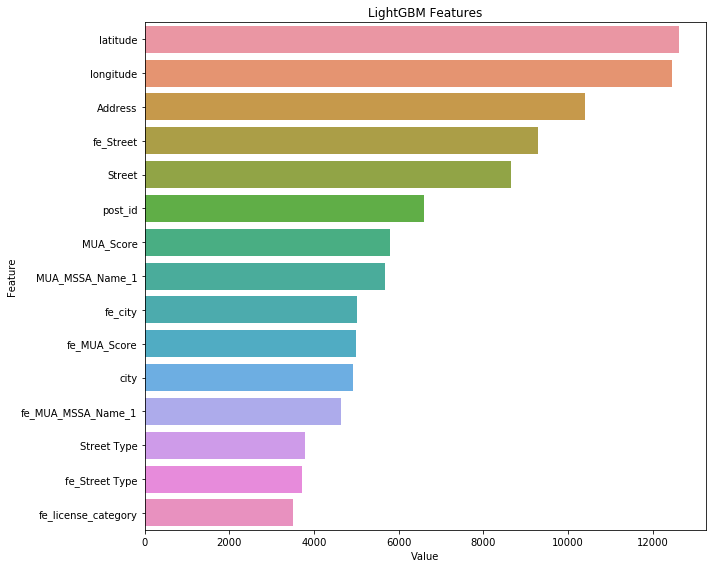

In [35]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(), X.columns), reverse=True)[:15],
                           columns=['Value','Feature'])
plt.figure(figsize=(10,8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [36]:
err = []
fold = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
for train_index, test_index in fold.split(X, y):
    
    X_train, X_cv = X.loc[train_index], X.loc[test_index]
    y_train, y_cv = y[train_index], y[test_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_cv, label=y_cv)
    
    clf = lgb.train(params=param, 
                     early_stopping_rounds=20,
                     verbose_eval=50,
                     train_set=train_data,
                     valid_sets=[train_data, val_data])

    y_pred = clf.predict(X_cv)
    print("Log Loss: ", (log_loss(y_cv, y_pred)))
    err.append(log_loss(y_cv, y_pred))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
[50]	training's multi_logloss: 1.24904	valid_1's multi_logloss: 1.24571
[100]	training's multi_logloss: 0.845442	valid_1's multi_logloss: 0.843148
[150]	training's multi_logloss: 0.606248	valid_1's multi_logloss: 0.605491
[200]	training's multi_logloss: 0.450067	valid_1's multi_logloss: 0.450753
[250]	training's multi_logloss: 0.341196	valid_1's multi_logloss: 0.343567
[300]	training's multi_logloss: 0.266625	valid_1's multi_logloss: 0.269993
[350]	training's multi_logloss: 0.211112	valid_1's multi_logloss: 0.214801
[400]	training's multi_logloss: 0.171363	valid_1's multi_logloss: 0.175564
[450]	training's multi_logloss: 0.139519	valid_1's multi_logloss: 0.144257
[500]	training's multi_logloss: 0.115075	valid_1's multi_logloss: 0.119994
[550]	training's multi_logloss: 0.0957829	valid_1's multi_logloss: 0.100491
[600]	training's multi_logloss: 0.0801282	valid_1's multi_logloss: 0.084472
[650]	training's multi_logloss: 0.067923

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	training's multi_logloss: 1.24747	valid_1's multi_logloss: 1.25417
[100]	training's multi_logloss: 0.84411	valid_1's multi_logloss: 0.852717
[150]	training's multi_logloss: 0.605749	valid_1's multi_logloss: 0.614679
[200]	training's multi_logloss: 0.448829	valid_1's multi_logloss: 0.458769
[250]	training's multi_logloss: 0.340113	valid_1's multi_logloss: 0.350227
[300]	training's multi_logloss: 0.265575	valid_1's multi_logloss: 0.275453
[350]	training's multi_logloss: 0.210127	valid_1's multi_logloss: 0.220122
[400]	training's multi_logloss: 0.170395	valid_1's multi_logloss: 0.179837
[450]	training's multi_logloss: 0.138793	valid_1's multi_logloss: 0.147719
[500]	training's multi_logloss: 0.114676	valid_1's multi_logloss: 0.123365
[550]	training's multi_logloss: 0.0954422	valid_1's multi_logloss: 0.103902
[600]	training's multi_logloss: 0.0797908	valid_1's multi_logloss: 0.0875756
[650]	training's multi_logloss: 0.067359	valid_1's multi_logloss: 0.0748152
[700]	training's multi_lo

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	training's multi_logloss: 1.24761	valid_1's multi_logloss: 1.25778
[100]	training's multi_logloss: 0.844254	valid_1's multi_logloss: 0.854605
[150]	training's multi_logloss: 0.605133	valid_1's multi_logloss: 0.614965
[200]	training's multi_logloss: 0.448965	valid_1's multi_logloss: 0.457905
[250]	training's multi_logloss: 0.34066	valid_1's multi_logloss: 0.348325
[300]	training's multi_logloss: 0.266181	valid_1's multi_logloss: 0.272907
[350]	training's multi_logloss: 0.211091	valid_1's multi_logloss: 0.217231
[400]	training's multi_logloss: 0.171023	valid_1's multi_logloss: 0.176645
[450]	training's multi_logloss: 0.139136	valid_1's multi_logloss: 0.144082
[500]	training's multi_logloss: 0.114864	valid_1's multi_logloss: 0.119415
[550]	training's multi_logloss: 0.095294	valid_1's multi_logloss: 0.0996248
[600]	training's multi_logloss: 0.0795603	valid_1's multi_logloss: 0.0838701
[650]	training's multi_logloss: 0.067069	valid_1's multi_logloss: 0.0715438
[700]	training's multi_lo

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	training's multi_logloss: 1.24877	valid_1's multi_logloss: 1.24766
[100]	training's multi_logloss: 0.844465	valid_1's multi_logloss: 0.844853
[150]	training's multi_logloss: 0.605207	valid_1's multi_logloss: 0.606893
[200]	training's multi_logloss: 0.449872	valid_1's multi_logloss: 0.452424
[250]	training's multi_logloss: 0.341152	valid_1's multi_logloss: 0.34454
[300]	training's multi_logloss: 0.266456	valid_1's multi_logloss: 0.270239
[350]	training's multi_logloss: 0.210825	valid_1's multi_logloss: 0.21505
[400]	training's multi_logloss: 0.170613	valid_1's multi_logloss: 0.175291
[450]	training's multi_logloss: 0.138911	valid_1's multi_logloss: 0.143712
[500]	training's multi_logloss: 0.114634	valid_1's multi_logloss: 0.119617
[550]	training's multi_logloss: 0.0952601	valid_1's multi_logloss: 0.100198
[600]	training's multi_logloss: 0.0798008	valid_1's multi_logloss: 0.0848808
[650]	training's multi_logloss: 0.0674343	valid_1's multi_logloss: 0.0723886
[700]	training's multi_lo

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	training's multi_logloss: 1.24515	valid_1's multi_logloss: 1.26386
[100]	training's multi_logloss: 0.83954	valid_1's multi_logloss: 0.865184
[150]	training's multi_logloss: 0.599953	valid_1's multi_logloss: 0.627942
[200]	training's multi_logloss: 0.445506	valid_1's multi_logloss: 0.473864
[250]	training's multi_logloss: 0.338057	valid_1's multi_logloss: 0.365871
[300]	training's multi_logloss: 0.263264	valid_1's multi_logloss: 0.289454
[350]	training's multi_logloss: 0.208205	valid_1's multi_logloss: 0.232315
[400]	training's multi_logloss: 0.168249	valid_1's multi_logloss: 0.190689
[450]	training's multi_logloss: 0.13662	valid_1's multi_logloss: 0.157789
[500]	training's multi_logloss: 0.11242	valid_1's multi_logloss: 0.132136
[550]	training's multi_logloss: 0.0934363	valid_1's multi_logloss: 0.111992
[600]	training's multi_logloss: 0.0782163	valid_1's multi_logloss: 0.0954191
[650]	training's multi_logloss: 0.0659867	valid_1's multi_logloss: 0.0821741
[700]	training's multi_log

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	training's multi_logloss: 1.24742	valid_1's multi_logloss: 1.24482
[100]	training's multi_logloss: 0.842389	valid_1's multi_logloss: 0.840103
[150]	training's multi_logloss: 0.603358	valid_1's multi_logloss: 0.601587
[200]	training's multi_logloss: 0.446928	valid_1's multi_logloss: 0.445594
[250]	training's multi_logloss: 0.338869	valid_1's multi_logloss: 0.338456
[300]	training's multi_logloss: 0.264538	valid_1's multi_logloss: 0.264878
[350]	training's multi_logloss: 0.209549	valid_1's multi_logloss: 0.210212
[400]	training's multi_logloss: 0.169669	valid_1's multi_logloss: 0.17083
[450]	training's multi_logloss: 0.137924	valid_1's multi_logloss: 0.139568
[500]	training's multi_logloss: 0.113721	valid_1's multi_logloss: 0.115913
[550]	training's multi_logloss: 0.094614	valid_1's multi_logloss: 0.0971794
[600]	training's multi_logloss: 0.079168	valid_1's multi_logloss: 0.0820485
[650]	training's multi_logloss: 0.0668495	valid_1's multi_logloss: 0.0700182
[700]	training's multi_lo

In [37]:
np.mean(err,0)

0.009714774071370103